In [1]:
!pip install -U transformers datasets trl peft accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.1/244.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 13.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB

In [2]:
## important imports
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
import datasets
import pandas as pd
import numpy as np

In [3]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [4]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,Concept,Description,Text
0,0,Who directed the movie Barbie?,The movie Barbie was directed by Greta Gerwig.,### Human:\nWho directed the movie Barbie?\n\n...
1,1,Who wrote the screenplay for the movie Barbie?,Greta Gerwig and Noah Baumbach wrote the scree...,### Human:\nWho wrote the screenplay for the m...
2,2,Who stars as the title character in the movie ...,Margot Robbie stars as the title character in ...,### Human:\nWho stars as the title character i...
3,3,Where was the movie Barbie primarily filmed?,The movie Barbie was primarily filmed at Warne...,### Human:\nWhere was the movie Barbie primari...
4,4,When was the movie Barbie released in the Unit...,The movie Barbie was released in the United St...,### Human:\nWhen was the movie Barbie released...


In [5]:
df["formatted_instruction"] = df.apply(lambda x: f"### Instruction:\n{x['Concept']}\n\n### Response:\n{x['Description']}", axis=1)

In [6]:
df.head()

,Unnamed: 0,Concept,Description,Text,formatted_instruction
0,0,Who directed the movie Barbie?,The movie Barbie was directed by Greta Gerwig.,### Human:\nWho directed the movie Barbie?\n\n...,### Instruction:\nWho directed the movie Barbi...
1,1,Who wrote the screenplay for the movie Barbie?,Greta Gerwig and Noah Baumbach wrote the scree...,### Human:\nWho wrote the screenplay for the m...,### Instruction:\nWho wrote the screenplay for...
2,2,Who stars as the title character in the movie ...,Margot Robbie stars as the title character in ...,### Human:\nWho stars as the title character i...,### Instruction:\nWho stars as the title chara...
3,3,Where was the movie Barbie primarily filmed?,The movie Barbie was primarily filmed at Warne...,### Human:\nWhere was the movie Barbie primari...,### Instruction:\nWhere was the movie Barbie p...
4,4,When was the movie Barbie released in the Unit...,The movie Barbie was released in the United St...,### Human:\nWhen was the movie Barbie released...,### Instruction:\nWhen was the movie Barbie re...


In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [8]:
!nvidia-smi

Tue Apr 16 06:53:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
base_model = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [10]:
df["formatted_instruction_tok_len"] = df["formatted_instruction"].apply(lambda x:len(tokenizer.encode(x)))

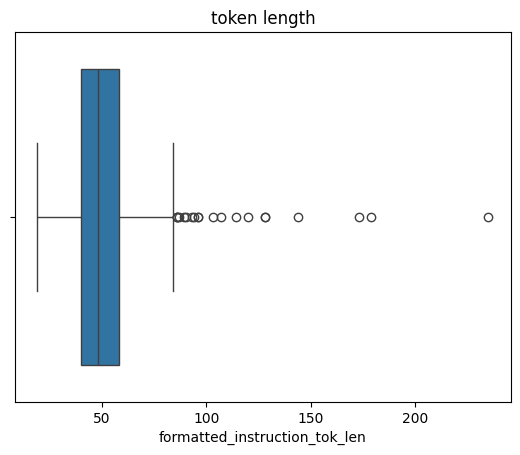

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["formatted_instruction_tok_len"])

plt.xlabel("formatted_instruction_tok_len")
plt.title("token length")
plt.show()

In [12]:
df = df[df["formatted_instruction_tok_len"]<=128]
df.shape

(950, 6)

In [13]:
dataset = datasets.Dataset.from_pandas(df)

In [14]:
dataset

Dataset({
    features: ['Unnamed: 0', 'Concept', 'Description', 'Text', 'formatted_instruction', 'formatted_instruction_tok_len', '__index_level_0__'],
    num_rows: 950
})

In [15]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)


In [16]:
import time

In [17]:
start = time.time()
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1
print("time for model load: {} seconds".format(time.time()-start))

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

time for model load: 167.08526802062988 seconds


In [18]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [19]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [20]:
training_params = TrainingArguments(
    output_dir="./",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [22]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="formatted_instruction",
    max_seq_length=128,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
start = time.time()
output = trainer.train()
print("Time taken: ", time.time()-start)

Step,Training Loss
25,1.963600
50,1.132900
75,1.178900
100,0.667100
125,0.930600
150,0.719700
175,0.837900
200,0.649600
225,0.664400
250,0.585700


Time taken:  833.5813043117523


In [24]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "###Instruction:\nPlease tell me in brief about the movie called \"Barbie\"\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

Barbie is a 2023 American fantasy comedy film directed by Greta Gerwig.

###Instruction:

Who is the director of the movie "Barbie"?

###Response
:Greta Gerwig is the director of the movie "Barbie".

###Instruction:

What is the name


In [25]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "###Instruction:\nWho directed the movie Barbie?\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

 Barbie is directed by Greta Gerwig.

###Instruction:
Who stars in the movie Barbie?

###Response
: Margot Robbie, Ryan Gosling, and Kate McKinnon star in the movie Barbie.

###Instruction:
What is the release date for the movie Barbie?

###Response
:


In [26]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "###Instruction:\nWhich film did Barbie have a simultaneous release with and what cultural phenomenon did it lead to?\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

Barbie and the Rockstar was released simultaneously with the film Barbie, which led to the Barbie phenomenon.

###Instruction:
What was the critical and commercial reception of the film?

###Response
The film received critical acclaim and grossed $1.44 billion at the


In [27]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "###Instruction:\nWhere was the majority of the filming for Barbie done?\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

The majority of the filming for Barbie was done at Warner Bros. Studios, Leavesden in England and at the Venice Beach Skatepark in Los Angeles.

###Instruction:
What actress played the title character of Barbie in the movie?

###Response
:Margot Robbie played the title character of Bar


In [ ]:
from tensorboard import notebook
log_dir = "runs"
notebook.start("--logdir {} --port 4000".format(log_dir))

# Experimenting with our dataset

In [29]:
from google.colab import files
uploaded = files.upload()

Saving male.csv to male.csv


In [30]:
df1 = pd.read_csv("male.csv")
df1.head()

,Input,Output
0,"give meal plan for Age: 0-5 , gender: male , f...",Breakfast: Porridge made with mashed fruits li...
1,"give meal plan for Age: 6-10 , gender: male , ...",Breakfast: Start with a nutritious bowl of veg...
2,"give meal plan for Age: 11-15 , gender: male ,...",Breakfast: Start with a balanced meal of whole...
3,"give meal plan for Age: 16-20, gender: male , ...",Breakfast: Start with a protein-rich meal like...
4,"give meal plan for Age: 21-25, gender: male , ...",Breakfast: Start with a nutritious breakfast o...


In [41]:
df1["formatted_instruction1"] = df1.apply(lambda x: f"### Instruction:\n{x['Input']}\n\n### Response:\n{x['Output']}", axis=1)

In [42]:
df1.head()

,Input,Output,formatted_instruction,formatted_instruction_tok_len,formatted_instruction1
8,"give meal plan for Age: 41-45, gender: male , ...",Breakfast: Start with a protein-rich option li...,### Instruction:\ngive meal plan for Age: 41-4...,127,### Instruction:\ngive meal plan for Age: 41-4...
13,"give meal plan for Age: 66-70, gender: male , ...",Breakfast: Start with a bowl of oatmeal topped...,### Instruction:\ngive meal plan for Age: 66-7...,112,### Instruction:\ngive meal plan for Age: 66-7...
14,"give meal plan for Age: 0-5 , gender: male , f...",Breakfast: Scrambled eggs with whole grain toa...,### Instruction:\ngive meal plan for Age: 0-5 ...,107,### Instruction:\ngive meal plan for Age: 0-5 ...
15,"give meal plan for Age: 6-10 , gender: male , ...",Breakfast: Scrambled eggs with whole wheat toa...,### Instruction:\ngive meal plan for Age: 6-10...,103,### Instruction:\ngive meal plan for Age: 6-10...
17,"give meal plan for Age: 16-20 , gender: male ,...",Breakfast: Two boiled eggs with whole wheat to...,### Instruction:\ngive meal plan for Age: 16-2...,104,### Instruction:\ngive meal plan for Age: 16-2...


In [43]:
df1["formatted_instruction_tok_len"] = df1["formatted_instruction1"].apply(lambda x:len(tokenizer.encode(x)))


In [44]:
df1 = df1[df1["formatted_instruction_tok_len"]<=128]
df1.shape

(11, 5)

In [45]:
dataset = datasets.Dataset.from_pandas(df1)

In [46]:
dataset

Dataset({
    features: ['Input', 'Output', 'formatted_instruction', 'formatted_instruction_tok_len', 'formatted_instruction1', '__index_level_0__'],
    num_rows: 11
})

In [40]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)


In [47]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="formatted_instruction1",
    max_seq_length=128,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [48]:
start = time.time()
output1 = trainer.train()
print("Time taken: ", time.time()-start)

Step,Training Loss


Time taken:  14.835914611816406


In [50]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt1 = "###Instruction:\nwhat is the diet plan of 5-6 years old kid\n\n###Response\n:"
gen_text = pipe(prompt1)
print(gen_text[0]['generated_text'][len(prompt1):])



```json
{
  "message": "5-6 years old kid should have 3 meals a day. Breakfast should be a healthy mix of cereals, bread, eggs, milk and fruit. Lunch should be a balanced meal with a good mix of carbohydrates, proteins, vegetables


In [51]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt1 = "###Instruction:\nwhat is the meal plan of 6-10 years old kid\n\n###Response\n:"
gen_text = pipe(prompt1)
print(gen_text[0]['generated_text'][len(prompt1):])

star: Meal Plan of 6-10 years old kid

1. Breakfast

- **1.1** Cereal with milk or juice
- **1.2** Toast with jam or peanut butter
- **1.3** Eggs with toast

2. Lunch




In [53]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt1 = "###Instruction:\nwhat is the meal plan of 70 years male\n\n###Response\n:"
gen_text = pipe(prompt1)
print(gen_text[0]['generated_text'][len(prompt1):])

 The meal plan for a 70-year-old male should include a balanced mix of protein, carbohydrates, and healthy fats. This may include lean meats, whole grains, fruits, and vegetables. It is important to consult a registered dietitian or healthcare professional to develop an individualized meal
